<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

#################################################################

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --quiet optuna


     |████████████████████████████████| 266kB 8.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 12.3MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 133kB 13.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 112kB 21.6MB/s 


In [25]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda



# PART 0 Preparing the dataset






get notMNIST dataset from repo
It is the small version

In [5]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

Cloning into 'NNDL_hw2'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 90 (delta 41), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [6]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

Read the folders

In [7]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#normalize images range
images_arr = images_arr/255

#free up some memory
del images

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [8]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
# print(letter[6])

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

Extend class Dataset

In [10]:
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])


0.0


Split dataset in train, validation, test

In [11]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


Show example of the dataset

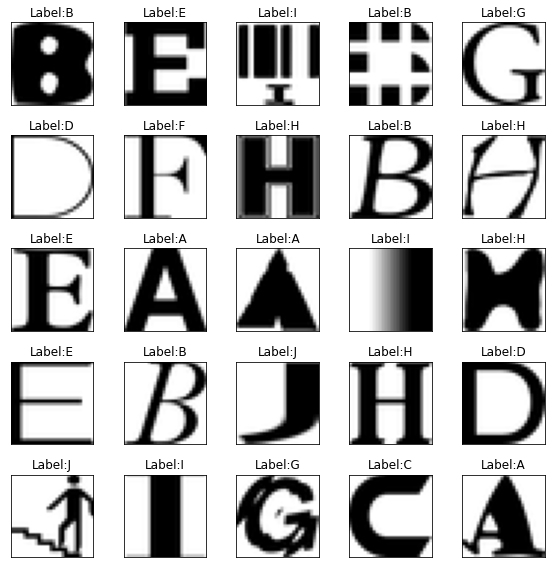

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Autoencoder Model Classes

In [13]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

same as the lab for now

In [14]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 3 * 3 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Training preparation

function for a single epoch training

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

function for a single epoch inference

In [17]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [18]:

# img, label = test_dataset[0]
# print(np.shape(img))
# print(letter[label])

# Optimized Search with Optuna

Optuna objective function

we need to put the training loop in the level of the objective function, and not as another function, in order to have a functioning trial.report used for pruning

In [26]:
def objective(trial):

    #suggest parameters
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'RMSprop'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    
    #make dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'RMSprop':
        optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

        if display:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(6,3))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)


        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [27]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=100)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-18 08:07:12,531] A new study created in memory with name: no-name-cff51925-3729-42e2-9dfb-9ac0735194ba


[I 2020-12-18 08:09:29,514] Trial 0 finished with value: 0.44273486733436584 and parameters: {'encoded_space_dim': 5, 'batch_size': 665, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.06329245902652032}. Best is trial 0 with value: 0.44273486733436584.


[I 2020-12-18 08:11:24,051] Trial 1 finished with value: 0.03943360596895218 and parameters: {'encoded_space_dim': 8, 'batch_size': 932, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.0025066984538931474}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:13:24,176] Trial 2 finished with value: 0.07367441058158875 and parameters: {'encoded_space_dim': 9, 'batch_size': 747, 'optim': 'RMSprop', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.00029787847619908896}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:15:56,944] Trial 3 finished with value: 0.05280543491244316 and parameters: {'encoded_space_dim': 8, 'batch_size': 660, 'optim': 'RMSprop', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0013824957187646722}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:18:15,699] Trial 4 finished with value: 0.19527210295200348 and parameters: {'encoded_space_dim': 5, 'batch_size': 844, 'optim': 'RMSprop', 'conv1_ch': 128, 'conv2_ch': 64, 'conv3_ch': 32, 'fc_ch': 64, 'lr': 0.016322401598616042}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:20:20,954] Trial 5 finished with value: 0.04223458096385002 and parameters: {'encoded_space_dim': 6, 'batch_size': 957, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005712361131175778}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:20:37,231] Trial 6 pruned. 


[I 2020-12-18 08:22:41,581] Trial 7 finished with value: 0.04010973870754242 and parameters: {'encoded_space_dim': 9, 'batch_size': 922, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0016338661260208243}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:22:57,604] Trial 8 pruned. 


[I 2020-12-18 08:24:58,741] Trial 9 finished with value: 0.051951538771390915 and parameters: {'encoded_space_dim': 8, 'batch_size': 553, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 128, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.04988952293606239}. Best is trial 1 with value: 0.03943360596895218.


[I 2020-12-18 08:25:12,915] Trial 10 pruned. 


[I 2020-12-18 08:27:08,031] Trial 11 finished with value: 0.03598674759268761 and parameters: {'encoded_space_dim': 10, 'batch_size': 997, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0044818961953306926}. Best is trial 11 with value: 0.03598674759268761.


[I 2020-12-18 08:29:03,165] Trial 12 finished with value: 0.03581509739160538 and parameters: {'encoded_space_dim': 10, 'batch_size': 987, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.00565512487851676}. Best is trial 12 with value: 0.03581509739160538.


[I 2020-12-18 08:30:58,380] Trial 13 finished with value: 0.03379955515265465 and parameters: {'encoded_space_dim': 10, 'batch_size': 997, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0069357977010046775}. Best is trial 13 with value: 0.03379955515265465.


[I 2020-12-18 08:32:53,559] Trial 14 finished with value: 0.04637887701392174 and parameters: {'encoded_space_dim': 10, 'batch_size': 819, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.00929036766510761}. Best is trial 13 with value: 0.03379955515265465.


[I 2020-12-18 08:34:49,786] Trial 15 finished with value: 0.032798074185848236 and parameters: {'encoded_space_dim': 10, 'batch_size': 513, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.014039853871296522}. Best is trial 15 with value: 0.032798074185848236.


[I 2020-12-18 08:36:20,509] Trial 16 pruned. 


[I 2020-12-18 08:38:18,431] Trial 17 finished with value: 0.04826287180185318 and parameters: {'encoded_space_dim': 9, 'batch_size': 351, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.010927534522079944}. Best is trial 15 with value: 0.032798074185848236.


[I 2020-12-18 08:38:32,513] Trial 18 pruned. 


[I 2020-12-18 08:38:46,414] Trial 19 pruned. 


[I 2020-12-18 08:39:41,359] Trial 20 pruned. 


[I 2020-12-18 08:41:39,102] Trial 21 finished with value: 0.02876577526330948 and parameters: {'encoded_space_dim': 10, 'batch_size': 326, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.006846632492020271}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:43:38,044] Trial 22 finished with value: 0.033627916127443314 and parameters: {'encoded_space_dim': 9, 'batch_size': 256, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.011680542129714401}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:45:36,339] Trial 23 finished with value: 0.03281207010149956 and parameters: {'encoded_space_dim': 9, 'batch_size': 290, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.01383019084787973}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:47:34,087] Trial 24 finished with value: 0.03597797825932503 and parameters: {'encoded_space_dim': 9, 'batch_size': 324, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.02250380866344056}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:49:31,847] Trial 25 finished with value: 0.0341319777071476 and parameters: {'encoded_space_dim': 8, 'batch_size': 321, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.002734616783378598}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:50:13,949] Trial 26 pruned. 


[I 2020-12-18 08:52:00,817] Trial 27 pruned. 


[I 2020-12-18 08:52:14,962] Trial 28 pruned. 


[I 2020-12-18 08:52:37,049] Trial 29 pruned. 


[I 2020-12-18 08:54:37,570] Trial 30 finished with value: 0.035836756229400635 and parameters: {'encoded_space_dim': 10, 'batch_size': 201, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.01744540255990151}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:56:36,779] Trial 31 finished with value: 0.03212922438979149 and parameters: {'encoded_space_dim': 9, 'batch_size': 260, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.009347356152881422}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 08:57:38,601] Trial 32 pruned. 


[I 2020-12-18 08:59:35,027] Trial 33 finished with value: 0.03134957328438759 and parameters: {'encoded_space_dim': 9, 'batch_size': 456, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0032294694081384896}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:00:09,929] Trial 34 pruned. 


[I 2020-12-18 09:00:24,891] Trial 35 pruned. 


[I 2020-12-18 09:02:40,812] Trial 36 finished with value: 0.02996244467794895 and parameters: {'encoded_space_dim': 10, 'batch_size': 365, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.003826168536804394}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:02:59,985] Trial 37 pruned. 


[I 2020-12-18 09:03:16,315] Trial 38 pruned. 


[I 2020-12-18 09:03:32,595] Trial 39 pruned. 


[I 2020-12-18 09:03:49,235] Trial 40 pruned. 


[I 2020-12-18 09:06:21,967] Trial 41 finished with value: 0.029226252809166908 and parameters: {'encoded_space_dim': 10, 'batch_size': 512, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.008162926487106105}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:08:54,899] Trial 42 finished with value: 0.031237179413437843 and parameters: {'encoded_space_dim': 10, 'batch_size': 479, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0075041504107535495}. Best is trial 21 with value: 0.02876577526330948.


[I 2020-12-18 09:11:27,834] Trial 43 finished with value: 0.028559748083353043 and parameters: {'encoded_space_dim': 10, 'batch_size': 470, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.001352184416138418}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:14:01,013] Trial 44 finished with value: 0.03402568772435188 and parameters: {'encoded_space_dim': 10, 'batch_size': 622, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0012877505312239822}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:16:33,301] Trial 45 finished with value: 0.02981325052678585 and parameters: {'encoded_space_dim': 10, 'batch_size': 580, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005473452379028596}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:19:05,587] Trial 46 finished with value: 0.028885889798402786 and parameters: {'encoded_space_dim': 10, 'batch_size': 562, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005680940456020514}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:21:38,155] Trial 47 finished with value: 0.029554754495620728 and parameters: {'encoded_space_dim': 10, 'batch_size': 559, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.006075882568613424}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:24:10,111] Trial 48 finished with value: 0.031842298805713654 and parameters: {'encoded_space_dim': 10, 'batch_size': 704, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.005409414872651285}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:24:28,488] Trial 49 pruned. 


[I 2020-12-18 09:24:46,755] Trial 50 pruned. 


[I 2020-12-18 09:25:05,146] Trial 51 pruned. 


[I 2020-12-18 09:27:37,318] Trial 52 finished with value: 0.030738217756152153 and parameters: {'encoded_space_dim': 10, 'batch_size': 577, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0023698600341919714}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:30:09,441] Trial 53 finished with value: 0.03141334652900696 and parameters: {'encoded_space_dim': 9, 'batch_size': 687, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.00772436599379543}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:30:27,786] Trial 54 pruned. 


[I 2020-12-18 09:30:46,076] Trial 55 pruned. 


[I 2020-12-18 09:31:04,431] Trial 56 pruned. 


[I 2020-12-18 09:31:22,850] Trial 57 pruned. 


[I 2020-12-18 09:33:55,437] Trial 58 finished with value: 0.03144409507513046 and parameters: {'encoded_space_dim': 9, 'batch_size': 608, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.007086445738755605}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:36:09,492] Trial 59 finished with value: 0.028647704049944878 and parameters: {'encoded_space_dim': 10, 'batch_size': 574, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0033135048441866664}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:36:36,529] Trial 60 pruned. 


[I 2020-12-18 09:36:52,611] Trial 61 pruned. 


[I 2020-12-18 09:37:08,840] Trial 62 pruned. 


[I 2020-12-18 09:39:22,663] Trial 63 finished with value: 0.029443852603435516 and parameters: {'encoded_space_dim': 10, 'batch_size': 581, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004820925300421315}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:41:36,343] Trial 64 finished with value: 0.03129024803638458 and parameters: {'encoded_space_dim': 10, 'batch_size': 581, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.009065824453748181}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:43:50,709] Trial 65 finished with value: 0.029311826452612877 and parameters: {'encoded_space_dim': 10, 'batch_size': 420, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0045523217104488254}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:46:05,625] Trial 66 finished with value: 0.03151644393801689 and parameters: {'encoded_space_dim': 9, 'batch_size': 421, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0018769521811625315}. Best is trial 43 with value: 0.028559748083353043.


[I 2020-12-18 09:46:21,786] Trial 67 pruned. 


[I 2020-12-18 09:48:36,933] Trial 68 finished with value: 0.028376691043376923 and parameters: {'encoded_space_dim': 10, 'batch_size': 406, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004495121421140488}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:50:52,913] Trial 69 finished with value: 0.0308231208473444 and parameters: {'encoded_space_dim': 9, 'batch_size': 314, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.003135157549210394}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:51:09,158] Trial 70 pruned. 


[I 2020-12-18 09:53:23,960] Trial 71 finished with value: 0.029306964948773384 and parameters: {'encoded_space_dim': 10, 'batch_size': 464, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0045431184994322625}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:55:38,889] Trial 72 finished with value: 0.029820194467902184 and parameters: {'encoded_space_dim': 10, 'batch_size': 428, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.0025830204639277553}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:57:53,333] Trial 73 finished with value: 0.0294319037348032 and parameters: {'encoded_space_dim': 10, 'batch_size': 481, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.004567046596576385}. Best is trial 68 with value: 0.028376691043376923.


[I 2020-12-18 09:58:09,723] Trial 74 pruned. 


[I 2020-12-18 09:58:28,623] Trial 75 pruned. 


[I 2020-12-18 10:00:44,466] Trial 76 finished with value: 0.028106437996029854 and parameters: {'encoded_space_dim': 10, 'batch_size': 334, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.004638933906517865}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:03:00,369] Trial 77 finished with value: 0.02832924574613571 and parameters: {'encoded_space_dim': 10, 'batch_size': 374, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0028424337469674208}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:05:16,004] Trial 78 finished with value: 0.030427463352680206 and parameters: {'encoded_space_dim': 9, 'batch_size': 348, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0016151454725103285}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:05:32,486] Trial 79 pruned. 


[I 2020-12-18 10:07:48,295] Trial 80 finished with value: 0.02928861789405346 and parameters: {'encoded_space_dim': 10, 'batch_size': 335, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0009652076339422087}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:08:04,560] Trial 81 pruned. 


[I 2020-12-18 10:10:20,505] Trial 82 finished with value: 0.030098123475909233 and parameters: {'encoded_space_dim': 10, 'batch_size': 338, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0010074910890455722}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:12:38,462] Trial 83 finished with value: 0.028977297246456146 and parameters: {'encoded_space_dim': 10, 'batch_size': 234, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0016234033894193891}. Best is trial 76 with value: 0.028106437996029854.


[I 2020-12-18 10:14:55,741] Trial 84 finished with value: 0.02689293585717678 and parameters: {'encoded_space_dim': 10, 'batch_size': 235, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002132581898452687}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:17:13,013] Trial 85 finished with value: 0.02931307442486286 and parameters: {'encoded_space_dim': 9, 'batch_size': 237, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002021629402559597}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:19:29,391] Trial 86 finished with value: 0.0279630608856678 and parameters: {'encoded_space_dim': 10, 'batch_size': 284, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0015599713389254893}. Best is trial 84 with value: 0.02689293585717678.


[I 2020-12-18 10:21:46,363] Trial 87 finished with value: 0.026848822832107544 and parameters: {'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:24:03,492] Trial 88 finished with value: 0.029968898743391037 and parameters: {'encoded_space_dim': 9, 'batch_size': 260, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.003471678767511506}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:26:20,343] Trial 89 finished with value: 0.029195517301559448 and parameters: {'encoded_space_dim': 10, 'batch_size': 265, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002326753502427592}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:28:36,786] Trial 90 finished with value: 0.029926620423793793 and parameters: {'encoded_space_dim': 9, 'batch_size': 300, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0014861078882850395}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:30:53,220] Trial 91 finished with value: 0.02755400538444519 and parameters: {'encoded_space_dim': 10, 'batch_size': 281, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002898519376048491}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:33:10,008] Trial 92 finished with value: 0.02982339821755886 and parameters: {'encoded_space_dim': 10, 'batch_size': 280, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0020431390338221714}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:35:28,191] Trial 93 finished with value: 0.028018241748213768 and parameters: {'encoded_space_dim': 10, 'batch_size': 219, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029112464151113547}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:37:46,427] Trial 94 finished with value: 0.027826504781842232 and parameters: {'encoded_space_dim': 10, 'batch_size': 214, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029238177058134827}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:40:04,549] Trial 95 finished with value: 0.028714381158351898 and parameters: {'encoded_space_dim': 10, 'batch_size': 218, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0012386506030087816}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:42:21,027] Trial 96 finished with value: 0.027792105451226234 and parameters: {'encoded_space_dim': 10, 'batch_size': 275, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002831317810374003}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:44:39,546] Trial 97 finished with value: 0.028191877529025078 and parameters: {'encoded_space_dim': 10, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.002493129854935254}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:46:57,102] Trial 98 finished with value: 0.027590015903115273 and parameters: {'encoded_space_dim': 10, 'batch_size': 228, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0029162972044557496}. Best is trial 87 with value: 0.026848822832107544.


[I 2020-12-18 10:49:15,639] Trial 99 finished with value: 0.028091447427868843 and parameters: {'encoded_space_dim': 10, 'batch_size': 202, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.001821221308967303}. Best is trial 87 with value: 0.026848822832107544.



val Loss: 0.026848822832107544
Best hyperparameters: {'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


In [28]:
best_params = trial.params
print(best_params)

{'encoded_space_dim': 10, 'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0033638691442384257}


In [29]:
# print(study.trials)
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_conv1_ch,params_conv2_ch,params_conv3_ch,params_encoded_space_dim,params_fc_ch,params_lr,params_optim,state
0,0,0.442735,2020-12-18 08:07:12.534452,2020-12-18 08:09:29.514226,0 days 00:02:16.979774,665,128,32,128,5,128,0.063292,Adam,COMPLETE
1,1,0.039434,2020-12-18 08:09:29.522092,2020-12-18 08:11:24.048993,0 days 00:01:54.526901,932,32,64,32,8,128,0.002507,Adam,COMPLETE
2,2,0.073674,2020-12-18 08:11:24.052691,2020-12-18 08:13:24.175247,0 days 00:02:00.122556,747,64,32,32,9,32,0.000298,RMSprop,COMPLETE
3,3,0.052805,2020-12-18 08:13:24.180522,2020-12-18 08:15:56.943575,0 days 00:02:32.763053,660,128,128,128,8,64,0.001382,RMSprop,COMPLETE
4,4,0.195272,2020-12-18 08:15:56.945818,2020-12-18 08:18:15.698572,0 days 00:02:18.752754,844,128,64,32,5,64,0.016322,RMSprop,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.028714,2020-12-18 10:37:46.428369,2020-12-18 10:40:04.548774,0 days 00:02:18.120405,218,64,128,128,10,128,0.001239,Adam,COMPLETE
96,96,0.027792,2020-12-18 10:40:04.559017,2020-12-18 10:42:21.027026,0 days 00:02:16.468009,275,64,128,128,10,128,0.002831,Adam,COMPLETE
97,97,0.028192,2020-12-18 10:42:21.035074,2020-12-18 10:44:39.546090,0 days 00:02:18.511016,202,64,128,128,10,128,0.002493,Adam,COMPLETE
98,98,0.027590,2020-12-18 10:44:39.559046,2020-12-18 10:46:57.101695,0 days 00:02:17.542649,228,64,128,128,10,128,0.002916,Adam,COMPLETE


In [34]:
csv_name = 'optuna100x50'
csv_path = '/content/drive/MyDrive/UNI ICT/NNDL/NNDL_hw2_data'
trials_df.to_csv(csv_path+csv_name)

visualization optuna

In [30]:
optuna.visualization.plot_optimization_history(study)

In [31]:
optuna.visualization.plot_slice(study)

train a model with the best parameters

EPOCH: 1/50


	 TRAINING - EPOCH 1/50 - loss: 0.113275




	 VALIDATION - EPOCH 1/50 - loss: 0.111401




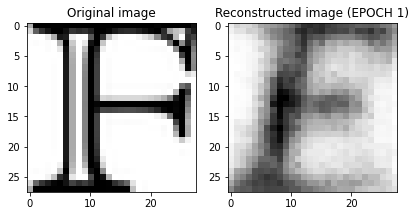

EPOCH: 2/50


	 TRAINING - EPOCH 2/50 - loss: 0.087378




	 VALIDATION - EPOCH 2/50 - loss: 0.076806




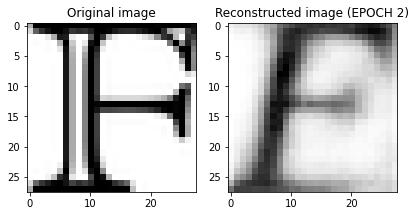

EPOCH: 3/50


	 TRAINING - EPOCH 3/50 - loss: 0.063397




	 VALIDATION - EPOCH 3/50 - loss: 0.057701




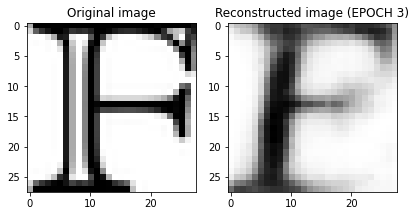

EPOCH: 4/50


	 TRAINING - EPOCH 4/50 - loss: 0.041753




	 VALIDATION - EPOCH 4/50 - loss: 0.046963




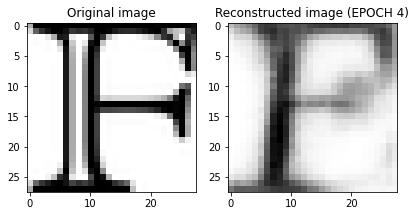

EPOCH: 5/50


	 TRAINING - EPOCH 5/50 - loss: 0.037868




	 VALIDATION - EPOCH 5/50 - loss: 0.040485




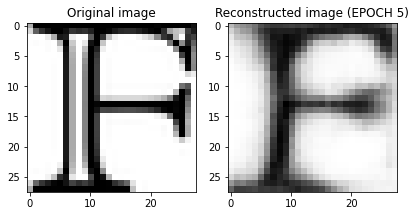

EPOCH: 6/50


	 TRAINING - EPOCH 6/50 - loss: 0.031878




	 VALIDATION - EPOCH 6/50 - loss: 0.039161




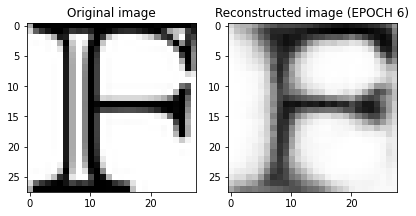

EPOCH: 7/50


	 TRAINING - EPOCH 7/50 - loss: 0.038136




	 VALIDATION - EPOCH 7/50 - loss: 0.034963




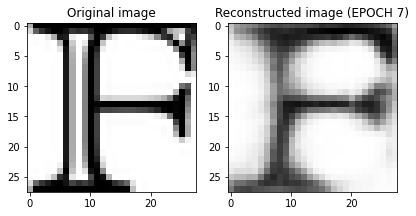

EPOCH: 8/50


	 TRAINING - EPOCH 8/50 - loss: 0.038773




	 VALIDATION - EPOCH 8/50 - loss: 0.033613




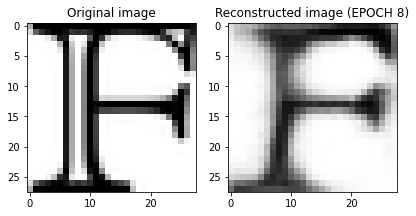

EPOCH: 9/50


	 TRAINING - EPOCH 9/50 - loss: 0.039492




	 VALIDATION - EPOCH 9/50 - loss: 0.033762




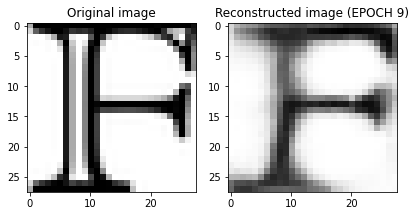

EPOCH: 10/50


	 TRAINING - EPOCH 10/50 - loss: 0.031568




	 VALIDATION - EPOCH 10/50 - loss: 0.032371




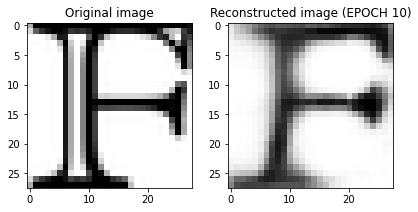

EPOCH: 11/50


	 TRAINING - EPOCH 11/50 - loss: 0.035074




	 VALIDATION - EPOCH 11/50 - loss: 0.033218




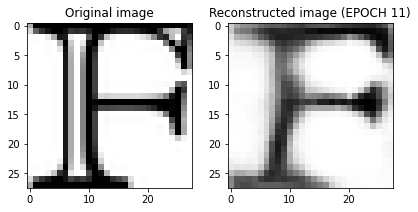

EPOCH: 12/50


	 TRAINING - EPOCH 12/50 - loss: 0.029731




	 VALIDATION - EPOCH 12/50 - loss: 0.033102




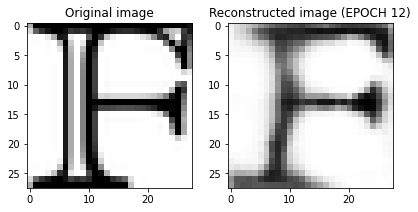

EPOCH: 13/50


	 TRAINING - EPOCH 13/50 - loss: 0.028800




	 VALIDATION - EPOCH 13/50 - loss: 0.030990




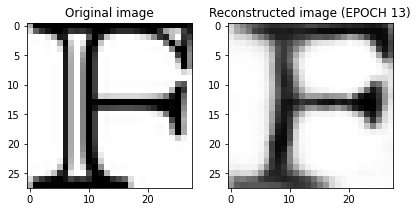

EPOCH: 14/50


	 TRAINING - EPOCH 14/50 - loss: 0.027557




	 VALIDATION - EPOCH 14/50 - loss: 0.030727




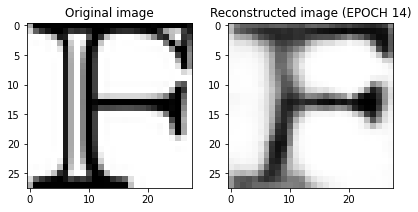

EPOCH: 15/50


	 TRAINING - EPOCH 15/50 - loss: 0.025613




	 VALIDATION - EPOCH 15/50 - loss: 0.030764




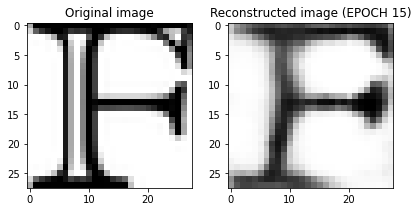

EPOCH: 16/50


	 TRAINING - EPOCH 16/50 - loss: 0.027596




	 VALIDATION - EPOCH 16/50 - loss: 0.030305




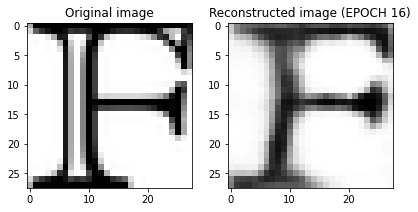

EPOCH: 17/50


	 TRAINING - EPOCH 17/50 - loss: 0.023081




	 VALIDATION - EPOCH 17/50 - loss: 0.029939




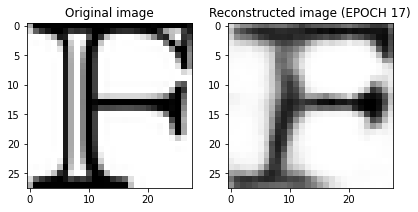

EPOCH: 18/50


	 TRAINING - EPOCH 18/50 - loss: 0.031411




	 VALIDATION - EPOCH 18/50 - loss: 0.029429




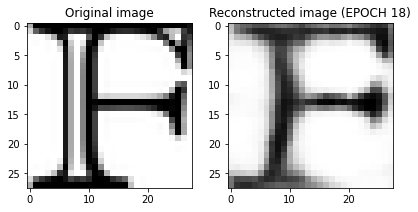

EPOCH: 19/50


	 TRAINING - EPOCH 19/50 - loss: 0.030195




	 VALIDATION - EPOCH 19/50 - loss: 0.029712




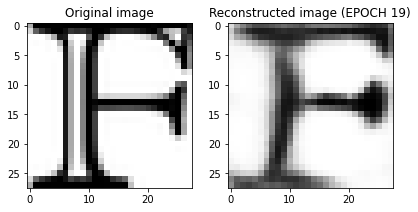

EPOCH: 20/50


	 TRAINING - EPOCH 20/50 - loss: 0.019684




	 VALIDATION - EPOCH 20/50 - loss: 0.028784




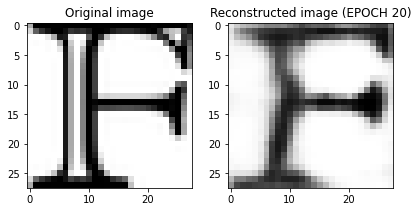

EPOCH: 21/50


	 TRAINING - EPOCH 21/50 - loss: 0.027726




	 VALIDATION - EPOCH 21/50 - loss: 0.029975




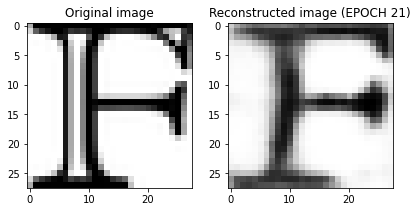

EPOCH: 22/50


	 TRAINING - EPOCH 22/50 - loss: 0.023675




	 VALIDATION - EPOCH 22/50 - loss: 0.030063




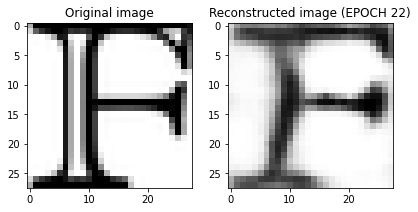

EPOCH: 23/50


	 TRAINING - EPOCH 23/50 - loss: 0.030488




	 VALIDATION - EPOCH 23/50 - loss: 0.029003




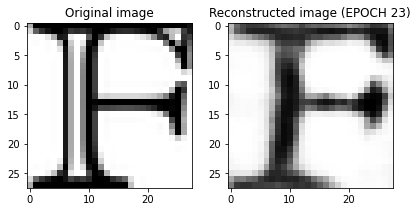

EPOCH: 24/50


	 TRAINING - EPOCH 24/50 - loss: 0.025479




	 VALIDATION - EPOCH 24/50 - loss: 0.028392




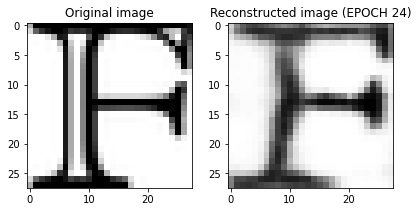

EPOCH: 25/50


	 TRAINING - EPOCH 25/50 - loss: 0.026359




	 VALIDATION - EPOCH 25/50 - loss: 0.029455




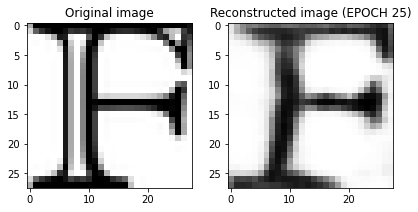

EPOCH: 26/50


	 TRAINING - EPOCH 26/50 - loss: 0.031799




	 VALIDATION - EPOCH 26/50 - loss: 0.028979




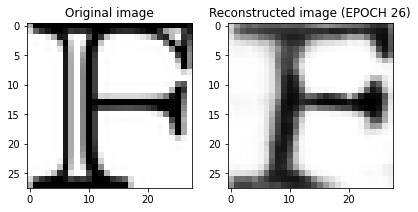

EPOCH: 27/50


	 TRAINING - EPOCH 27/50 - loss: 0.025033




	 VALIDATION - EPOCH 27/50 - loss: 0.028538




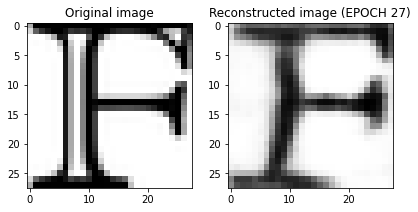

EPOCH: 28/50


	 TRAINING - EPOCH 28/50 - loss: 0.026402




	 VALIDATION - EPOCH 28/50 - loss: 0.029669




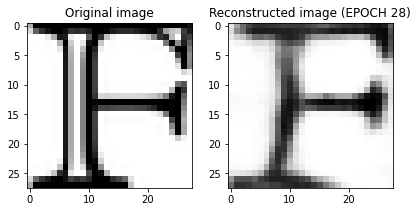

EPOCH: 29/50


	 TRAINING - EPOCH 29/50 - loss: 0.027089




	 VALIDATION - EPOCH 29/50 - loss: 0.027702




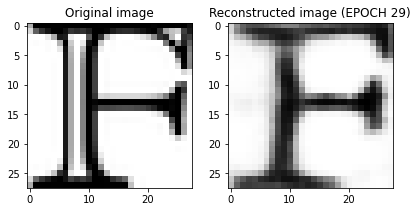

EPOCH: 30/50


	 TRAINING - EPOCH 30/50 - loss: 0.025366




	 VALIDATION - EPOCH 30/50 - loss: 0.029007




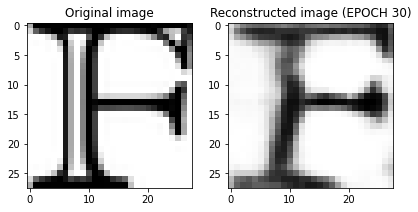

EPOCH: 31/50


	 TRAINING - EPOCH 31/50 - loss: 0.022449




	 VALIDATION - EPOCH 31/50 - loss: 0.028536




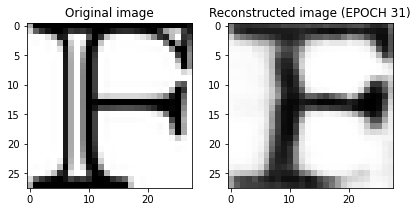

EPOCH: 32/50


	 TRAINING - EPOCH 32/50 - loss: 0.025190




	 VALIDATION - EPOCH 32/50 - loss: 0.028368




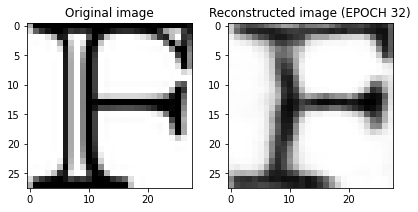

EPOCH: 33/50


	 TRAINING - EPOCH 33/50 - loss: 0.022680




	 VALIDATION - EPOCH 33/50 - loss: 0.029326




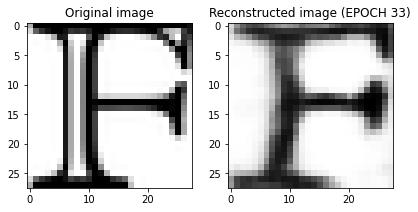

EPOCH: 34/50


	 TRAINING - EPOCH 34/50 - loss: 0.022689




	 VALIDATION - EPOCH 34/50 - loss: 0.027848




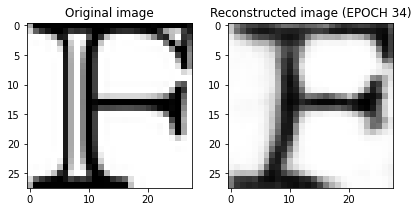

EPOCH: 35/50


	 TRAINING - EPOCH 35/50 - loss: 0.021346




	 VALIDATION - EPOCH 35/50 - loss: 0.027808




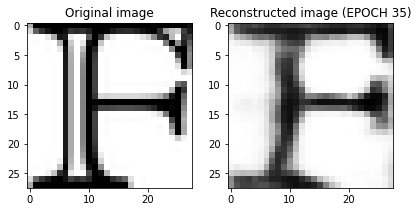

EPOCH: 36/50


	 TRAINING - EPOCH 36/50 - loss: 0.023690




	 VALIDATION - EPOCH 36/50 - loss: 0.027786




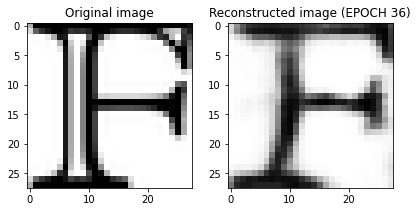

EPOCH: 37/50


	 TRAINING - EPOCH 37/50 - loss: 0.024743




	 VALIDATION - EPOCH 37/50 - loss: 0.030837




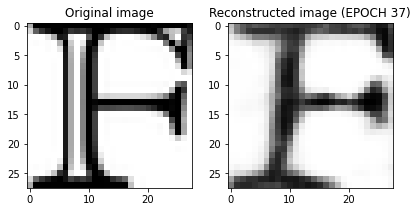

EPOCH: 38/50


	 TRAINING - EPOCH 38/50 - loss: 0.027831




	 VALIDATION - EPOCH 38/50 - loss: 0.027751




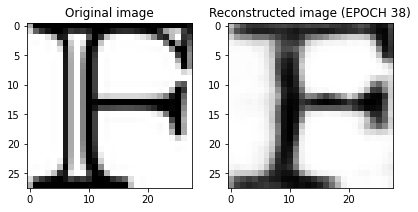

EPOCH: 39/50


	 TRAINING - EPOCH 39/50 - loss: 0.026988




	 VALIDATION - EPOCH 39/50 - loss: 0.028001




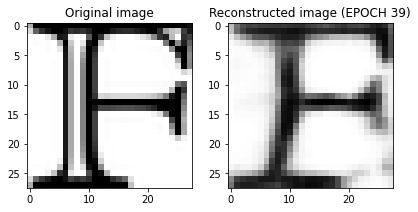

EPOCH: 40/50


	 TRAINING - EPOCH 40/50 - loss: 0.022617




	 VALIDATION - EPOCH 40/50 - loss: 0.028328




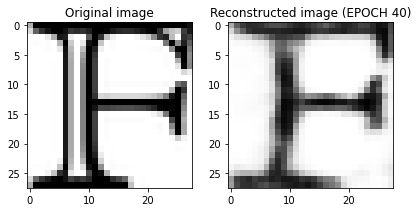

EPOCH: 41/50


	 TRAINING - EPOCH 41/50 - loss: 0.024364




	 VALIDATION - EPOCH 41/50 - loss: 0.028302




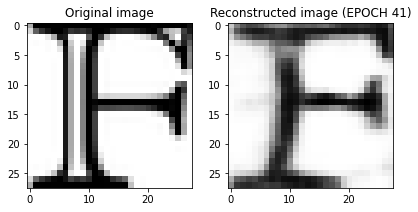

EPOCH: 42/50


	 TRAINING - EPOCH 42/50 - loss: 0.024519




	 VALIDATION - EPOCH 42/50 - loss: 0.027475




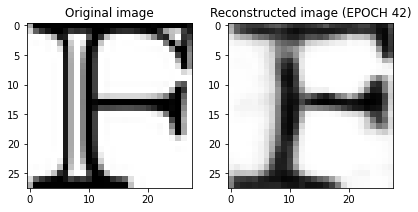

EPOCH: 43/50


	 TRAINING - EPOCH 43/50 - loss: 0.018469




	 VALIDATION - EPOCH 43/50 - loss: 0.027382




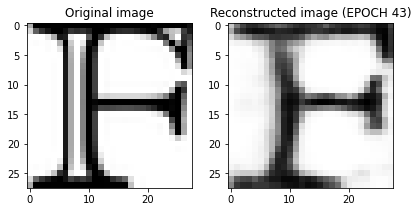

EPOCH: 44/50


	 TRAINING - EPOCH 44/50 - loss: 0.018848




	 VALIDATION - EPOCH 44/50 - loss: 0.027774




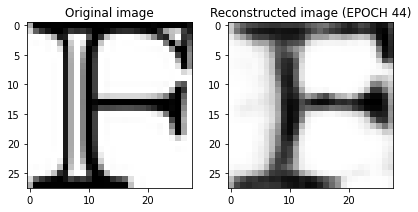

EPOCH: 45/50


	 TRAINING - EPOCH 45/50 - loss: 0.018168




	 VALIDATION - EPOCH 45/50 - loss: 0.028062




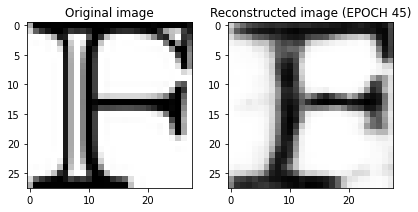

EPOCH: 46/50


	 TRAINING - EPOCH 46/50 - loss: 0.024149




	 VALIDATION - EPOCH 46/50 - loss: 0.028991




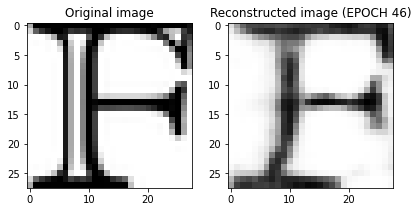

EPOCH: 47/50


	 TRAINING - EPOCH 47/50 - loss: 0.020568




	 VALIDATION - EPOCH 47/50 - loss: 0.027494




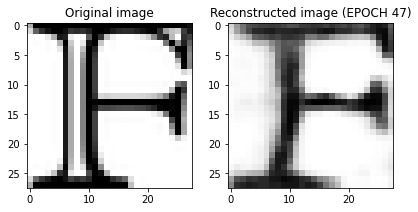

EPOCH: 48/50


	 TRAINING - EPOCH 48/50 - loss: 0.022460




	 VALIDATION - EPOCH 48/50 - loss: 0.027870




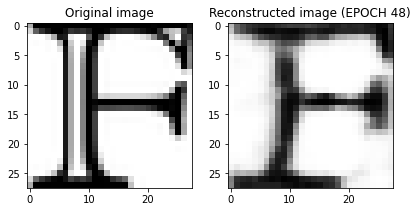

EPOCH: 49/50


	 TRAINING - EPOCH 49/50 - loss: 0.021234




	 VALIDATION - EPOCH 49/50 - loss: 0.027940




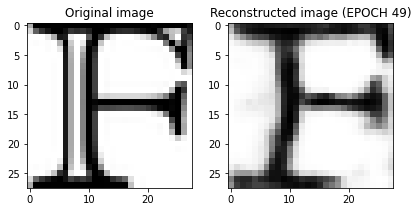

EPOCH: 50/50


	 TRAINING - EPOCH 50/50 - loss: 0.025414




	 VALIDATION - EPOCH 50/50 - loss: 0.027801




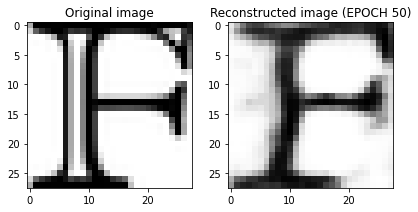

In [33]:
encoded_space_dim = best_params['encoded_space_dim']
batch_size = best_params['batch_size']
lr = best_params['lr']
optim = best_params['optim']

conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']

#make dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# initialize models
encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = True
num_epochs = 50

train_loss_record = []
val_loss_record = []
for epoch in range(num_epochs):
    
    print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

    if display:
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)


In [35]:
best_encoder = encoder
best_decoder = decoder

## Examples of reconstructed samples

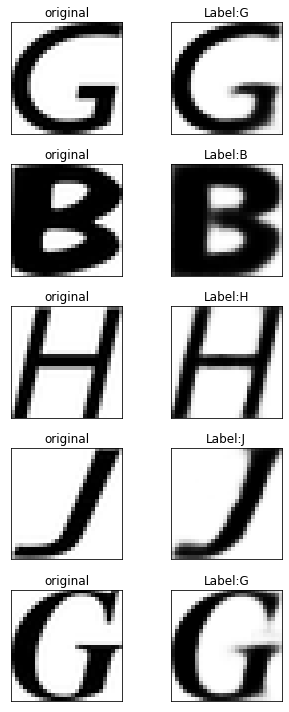

In [38]:
rows = 5
fig, ax = plt.subplots(5, 2, figsize=(rows,rows*2))
for i in range(rows):
    img, label = random.choice(test_dataset)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i,0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,0].set_title('original')
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    ax[i,1].set_title(f'Label:{letter[label]}' )
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
plt.tight_layout()

# Latent space analysis

In [ ]:
# # Load network parameters
# encoder.load_state_dict(torch.load('encoder_params.pth'))
# decoder.load_state_dict(torch.load('decoder_params.pth'))

Function for generation of encoded samples

In [ ]:
### Get the encoded representation of the test samples
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = letter[label]
        encoded_samples.append(encoded_sample)
    
    return encoded_samples

In [ ]:
encoded_samples = make_encoded_samples(test_dataset, best_encoder, device)


100%|██████████| 3745/3745 [00:02<00:00, 1497.54it/s]


In [ ]:
print(np.shape(encoded_samples))

(3745, 5)


## Encoded examples

In [ ]:
# print(type(encoded_samples))
# print(np.shape(encoded_samples))
# print(encoded_samples[0])

<class 'list'>
(3745,)
{'Enc. Variable 0': 26.27268, 'Enc. Variable 1': -8.605742, 'Enc. Variable 2': -4.129607, 'label': 5.0}


In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

## PCA if dim > 2

In [39]:
if encoded_space_dim > 2:
    PCAobj = PCA(n_components=2)
    PCAobj.fit(encoded_samples.iloc[:,0:encoded_space_dim])
    encoded_samples_reduced = PCAobj.transform(encoded_samples.iloc[:,0:encoded_space_dim])

    encoded_samples_reduced = pd.DataFrame(encoded_samples_reduced)
    # encoded_samples_reduced.insert(encoded_space_dim, "label", encoded_samples["label"], True)
    encoded_samples_reduced['label'] = encoded_samples['label']
    encoded_samples_reduced.columns = ['Enc. Variable 0', 'Enc. Variable 1', 'label']
    encoded_samples_reduced

    # print(PCAobj.explained_variance_ratio_)
    # print(type(encoded_samples_reduced))
    # print(np.shape(encoded_samples_reduced))
else:
    encoded_samples_reduced = encoded_samples
    print("no need for PCA")
    

NameError: ignored

In [ ]:
encoded_samples_reduced

,Enc. Variable 0,Enc. Variable 1,label
0,-1.117078,-4.228733,F
1,2.604879,8.235542,H
2,0.917114,10.803856,H
3,-8.326650,3.242149,G
4,3.803149,7.918033,D
...,...,...,...
3740,-9.271940,3.282143,C
3741,-1.007177,-1.053270,D
3742,2.659192,6.375285,H
3743,11.396126,-4.465239,J


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [ ]:
import plotly.express as px
px.scatter(encoded_samples_reduced, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

# PART 2 Denoising autoencoder